In [1]:
#https://aidanrussellcom.wordpress.com/2019/01/14/pystan-tutorial-1/

In [2]:
# TODO try np.exp or x**2, etc for prop
# TODO try larger dataset

In [3]:
import numpy as np
import pandas as pd
import stan as ps
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from utils import get_data
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=800)
# train = train[train["dist"] == "10K"]

# train["prop2"] = np.exp(train["prop"])
# test["prop2"] = np.exp(test["prop"])

train["prop2"] = train["prop"] ** 2
test["prop2"] = test["prop"] ** 2
train.to_csv("train.csv")
test.to_csv("test.csv")

In [4]:
ols_model = smf.ols(formula="finish ~ total_pace + curr_pace + prop", data=train)  # np.exp(prop)
ols_fit = ols_model.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 finish   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 4.403e+04
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:53:53   Log-Likelihood:                 4710.1
No. Observations:                8000   AIC:                            -9412.
Df Residuals:                    7996   BIC:                            -9384.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2486      0.010    -24.176      0.0

In [5]:
# ols_fit.get_prediction(test).summary_frame(alpha=0.05)

In [6]:
! python pystan_code.py #2.5mins total: train=500

8000
start
Building: found in cache, done.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000688 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.88 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000688 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.88 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001073 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.73 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000718 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.18 seconds.
  Adjust your expectations accordingly!
loading:  5K
Building: found in cache, done.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  12% (1000/8000)
Sampling:  19% (1500/8000)
Sampling:  26% (2100/800

In [7]:
import pandas as pd
# stan_results = pd.read_csv("stan_results/ps_result.csv") #stan_results = pd.read_csv("ps_result5K.csv")

# marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
# sep_results = {mk: pd.read_csv(f"stan_results/ps_result{mk}.csv") for mk in marks}
# stan_results.describe()

marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
stan_results1 = pd.read_csv("stan_results/bayes1/ps_result.csv")
stan_results2 = pd.read_csv("stan_results/bayes2/ps_result.csv")

sep_results1 = {mk: pd.read_csv(f"stan_results/bayes1/ps_result{mk}.csv") for mk in marks}
sep_results2 = {mk: pd.read_csv(f"stan_results/bayes2/ps_result{mk}.csv") for mk in marks}
stan_results2.describe()

,draws,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta.1,beta.2,beta.3,sigma
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,12057.038265,0.937644,0.026028,6.42300,122.984500,0.0,-12054.541702,-0.248759,0.705087,0.290466,0.315215,0.134356
std,1154.844867,1.639153,0.089683,0.001799,1.00091,57.970172,0.0,2.300926,0.010185,0.012866,0.011973,0.006661,0.001102
min,0.000000,12046.192372,0.317368,0.023204,1.00000,1.000000,0.0,-12059.080622,-0.288747,0.663051,0.245798,0.293009,0.130668
25%,999.750000,12056.214245,0.913812,0.025099,6.00000,87.000000,0.0,-12056.217556,-0.255172,0.696452,0.282190,0.310791,0.133599
50%,1999.500000,12057.381755,0.975200,0.026649,7.00000,127.000000,0.0,-12054.905495,-0.248803,0.705364,0.290298,0.315407,0.134331
75%,2999.250000,12058.226318,0.996800,0.027578,7.00000,127.000000,0.0,-12053.264026,-0.241996,0.713959,0.298573,0.319696,0.135099
max,3999.000000,12059.516225,1.000000,0.027612,8.00000,255.000000,0.0,-12042.567338,-0.215513,0.749221,0.332169,0.338122,0.139033


In [8]:
# pd.DataFrame([sep_results[mk][["alpha", "beta.1", "beta.2", "sigma"]].mean() for mk in marks])

In [9]:
# plt.plot(pd.DataFrame([sep_results[mk][["alpha", "beta.1", "beta.2", "sigma"]].mean() for mk in marks]))
# plt.legend()

In [10]:
def full_predictions(test_data, stan_data, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats]
    d2 = stan_data[betas].T.copy()
    # preds = (stan_data["alpha"] + d1.dot(d2.values))#.mean(axis=1)
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"])#.mean(axis=1)
    # print(preds)
    # test_new[name] = preds
    return preds#test_new

def get_predictions(test_data, stan_data, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats]
    d2 = stan_data[betas].T.copy()
    # preds = (stan_data["alpha"] + d1.dot(d2.values)).mean(axis=1)
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"]).mean(axis=1)
    test_new[name] = preds
    return test_new

def get_table(test_data, old="stan_pred", new="stan"):
    y_true = (42195 / 60) / test_data["finish"]
    preds = (42195 / 60) / test_data[old]
    extrap = (42195 / 60) / test_data["total_pace"]
    test_data[new] = preds - y_true
    test_data["extrap"] = extrap - y_true
    return test_data

In [11]:
betas = ["beta.1", "beta.2"]
feats = ["total_pace", "prop"]
test_pred_t1 = get_predictions(test, stan_results1)

betas = ["beta.1", "beta.2", "beta.3"]
feats = ["total_pace", "curr_pace", "prop"]
test_pred_t2 = get_predictions(test, stan_results2)

betas = ["beta.1"]
feats = ["total_pace"]
test_pred_s1 = pd.concat([get_predictions(test_pred_t1[test_pred_t1["dist"] == mk], sep_results1[mk]) for mk in marks])

betas = ["beta.1", "beta.2"]
feats = ["total_pace", "curr_pace"]
test_pred_s2 = pd.concat([get_predictions(test_pred_t2[test_pred_t2["dist"] == mk], sep_results2[mk]) for mk in marks])

In [12]:
table = get_table(test_pred_t1).copy()
table["bayes1_sep"] = get_table(test_pred_s1)["stan"]
table["bayes2_sep"] = get_table(test_pred_s2)["stan"]
table["bayes1_stan"] = get_table(test_pred_t1)["stan"]
table["bayes2_stan"] = get_table(test_pred_t2)["stan"]
table

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,prop2,stan_pred,stan,extrap,bayes1_sep,bayes2_sep,bayes1_stan,bayes2_stan
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.014042,4.948263,1.987249,-3.702833,0.432233,0.511506,1.987249,2.817397
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.014042,4.468608,12.408953,5.388183,11.105138,10.693737,12.408953,13.328965
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.014042,4.691548,3.597226,-2.696350,2.082470,2.183982,3.597226,4.670089
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.014042,4.914477,-5.869031,-11.551617,-7.366428,-7.063722,-5.869031,-5.012253
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.014042,4.405667,10.240631,2.940617,8.760798,8.734304,10.240631,10.832688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.898665,1.919852,6.770990,-0.910996,0.214030,1.504542,6.770990,9.955284
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.898665,1.921855,5.589223,-2.888940,-1.691571,-1.569328,5.589223,2.110845
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.898665,1.918351,4.774165,-2.965773,-1.777515,-1.344441,4.774165,3.336859
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.898665,1.926549,2.964364,-4.780504,-3.550946,0.240981,2.964364,17.133860


         extrap  bayes1_sep  bayes2_sep  bayes1_stan  bayes2_stan
dist                                                             
5K    18.266615   15.736424   15.751810    16.528944    16.714922
10K   17.293082   13.306966   12.566656    13.316473    12.856229
15K   15.891527   11.559868   10.142669    11.335664    10.662772
20K   13.460085    9.642344    9.678155     9.338140     8.467118
25K   11.258575    8.076614    6.331764     7.698016     6.593157
30K    7.920076    6.047803    4.381177     5.934364     4.679391
35K    4.376820    3.796089    2.756161     4.435624     3.989283
40K    1.179431    1.141627    0.905220     2.608737     4.023170


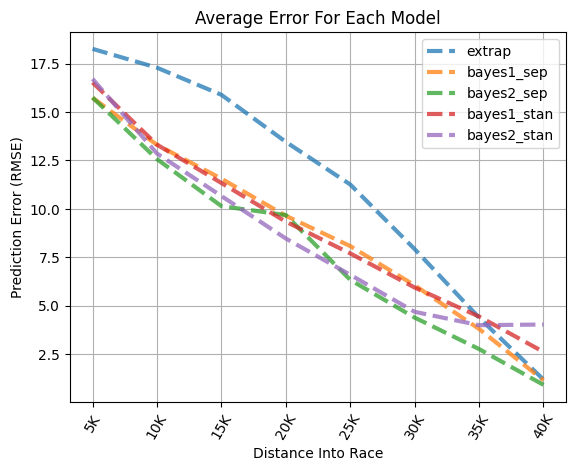

In [13]:
labels = ["extrap", "stan", "stan_sep"]#, "bayes2", "quant1", "quant2"]
labels = ["extrap", "bayes1_sep", "bayes2_sep", "bayes1_stan", "bayes2_stan"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table = table.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table)
table.plot(label=table.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
plt.savefig("analysis/all_errors_new1.png", bbox_inches="tight")

In [14]:
edcvfrvfv

NameError: name 'edcvfrvfv' is not defined

         extrap       stan   stan_sep
dist                                 
5K    18.266615  16.734009  15.749235
10K   17.293082  12.857463  12.573837
15K   15.891527  10.653932  10.122575
20K   13.460085   8.458256   9.654813
25K   11.258575   6.594300   6.327345
30K    7.920076   4.676508   4.387500
35K    4.376820   3.990914   2.754694
40K    1.179431   4.028530   0.904918


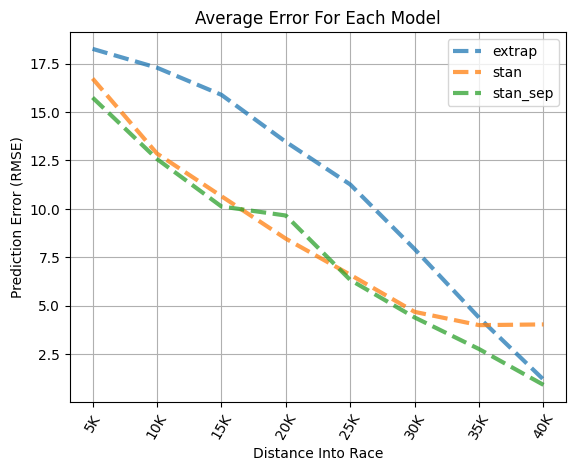

In [ ]:
labels = ["extrap", "stan", "stan_sep"]#, "bayes2", "quant1", "quant2"]
colors = ["C0", "C1", "C2"]#, "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table = table.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table)
table.plot(label=table.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/all_errors.png", bbox_inches="tight")

In [ ]:
full_preds =  (42195 / 60) / full_predictions(test, stan_results)

In [ ]:
full_preds.shape

(6400, 4000)

In [ ]:
table.groupby(["dist"])[labels].apply(lambda x: (x).std()).loc[mks]#(lambda x: (x ** 2).mean() ** 0.5).loc[mks]

,extrap,stan,stan_sep
dist,,,
5K,15.949819,15.081874,15.054839
10K,14.106589,12.550580,12.453838
15K,12.538198,10.627035,9.938870
20K,10.454158,8.445494,9.480657
25K,8.586612,6.569987,6.153983
30K,6.273249,4.503148,4.368317
35K,3.827642,3.293556,2.756398
40K,1.103764,4.030940,0.905174


In [ ]:
test.groupby(["dist"])["finish"].apply(lambda x: x.std())

dist
10K    0.581274
15K    0.581274
20K    0.581274
25K    0.581274
30K    0.581274
35K    0.581274
40K    0.581274
5K     0.581274
Name: finish, dtype: float64

In [ ]:
test["finish"]

28        5.018435
71        4.851115
85        4.806904
120       4.720855
125       4.707687
            ...   
208126    1.956008
208138    1.951665
208148    1.943664
208150    1.942322
208209    1.855622
Name: finish, Length: 6400, dtype: float64

(0.0, 0.9)

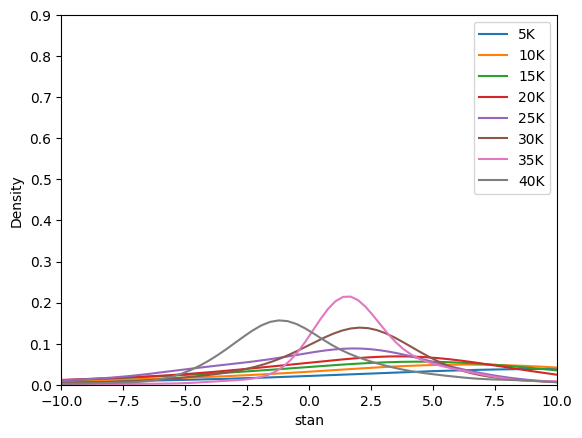

In [ ]:
import seaborn as sns
for mk in marks:
    q = table[table["dist"] == mk]
    sns.kdeplot(q["stan"], label=mk)

plt.legend()
plt.xlim(-10, 10)
plt.ylim(0, 0.9)

(0.0, 0.9)

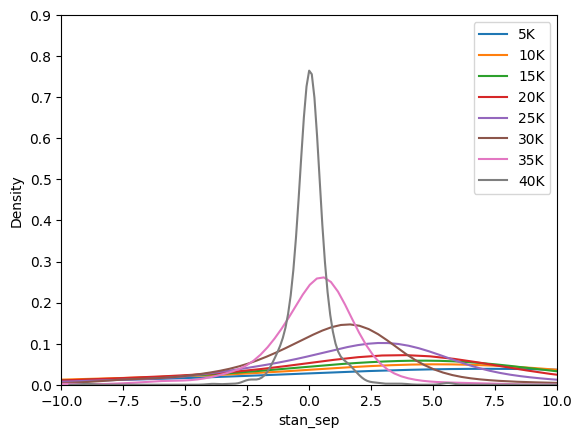

In [ ]:
import seaborn as sns
for mk in marks:
    q = table[table["dist"] == mk]
    sns.kdeplot(q["stan_sep"], label=mk)

plt.legend()
plt.xlim(-10, 10)
plt.ylim(0, 0.9)

In [ ]:
np.percentile(full_preds, [10, 25, 50, 75, 90], axis=1)#.shape

array([[139.03289495, 153.63992547, 146.46085745, ..., 390.33694513,
        406.75994791, 405.28198105],
       [141.4203389 , 156.4270827 , 149.0417797 , ..., 408.85863198,
        426.44473007, 424.90002421],
       [144.11878001, 159.61989811, 152.00183162, ..., 431.66804974,
        452.55500693, 449.73208178],
       [146.91369195, 162.99502386, 154.9473034 , ..., 456.82991301,
        479.64420902, 476.609079  ],
       [149.39905835, 166.15064522, 157.80799753, ..., 482.65993647,
        510.69341188, 505.41305486]])

In [ ]:
a, b = np.percentile(full_preds, [10, 90], axis=1)#.shape
b - a

array([ 10.3661634 ,  12.51071975,  11.34714008, ...,  92.32299134,
       103.93346397, 100.1310738 ])

In [ ]:
full_preds[0]

array([148.45791649, 147.11360485, 143.61011061, ..., 140.15979901,
       145.3185692 , 143.13044376])

<Axes: ylabel='Density'>

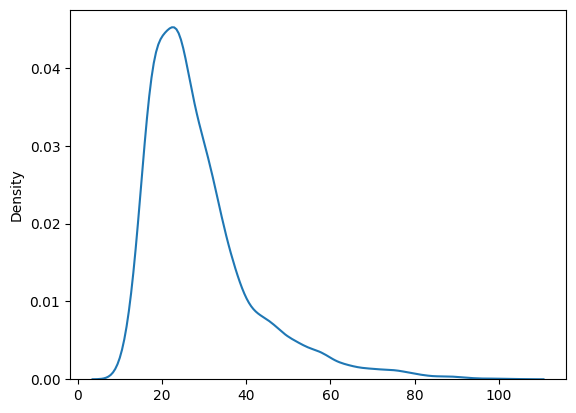

In [ ]:
import seaborn as sns
sns.kdeplot(b - a)

In [15]:
def add_intervals_to_test(test_data, b1, b2, q1, q2):
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / test_data["finish"]
        b11, b12 = np.percentile(b1, [lower, upper], axis=1)
        test_data[f"bayes1-lower{conf}"] = b11
        test_data[f"bayes1-upper{conf}"] = b12
        test_data[f"bayes1-size{conf}"] = b12 - b11
        test_data[f"bayes1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(b2, [lower, upper], axis=1)
        test_data[f"bayes2-lower{conf}"] = b21
        test_data[f"bayes2-upper{conf}"] = b22
        test_data[f"bayes2-size{conf}"] = b22 - b21
        test_data[f"bayes2-in{conf}"] = (test_true < b22) & (test_true > b21)

        q11, q12 = get_quants(train, test, formula="finish ~ total_pace + dist", quantiles=[lower, upper])
        test_data[f"quant1-lower{conf}"] = q11
        test_data[f"quant1-upper{conf}"] = q12
        test_data[f"quant1-size{conf}"] = q12 - q11
        test_data[f"quant1-in{conf}"] = (test_true < q12) & (test_true > q11)

        q21, q22 = get_quants(train, test, formula="finish ~ total_pace + curr_pace + dist", quantiles=[lower, upper])
        test_data[f"quant2-lower{conf}"] = q21
        test_data[f"quant2-upper{conf}"] = q22
        test_data[f"quant2-size{conf}"] = q22 - q21
        test_data[f"quant2-in{conf}"] = (test_true < q22) & (test_true > q21)

    return test_data

test = add_intervals_to_test(test, b1, b2, q1, q2)

NameError: name 'b1' is not defined

In [ ]:
# import arviz as az
# idata = az.from_netcdf("save_idata.nc")